In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

In [39]:
# Carregar os dados
customers_df = pd.read_csv('../data/olist_customers_dataset.csv')
geolocation_df = pd.read_csv('../data/olist_geolocation_dataset.csv')
orders_items_df = pd.read_csv('../data/olist_order_items_dataset.csv')
payments_df = pd.read_csv('../data/olist_order_payments_dataset.csv')
reviews_df = pd.read_csv('../data/olist_order_reviews_dataset.csv')
orders_df = pd.read_csv('../data/olist_orders_dataset.csv')
products_df = pd.read_csv('../data/olist_products_dataset.csv')
sellers_df = pd.read_csv('../data/olist_sellers_dataset.csv')

In [40]:
# Fazer o merge entre os datasets
merged_df = pd.merge(orders_items_df, products_df, on='product_id', how='inner')
merged_df = pd.merge(merged_df, orders_df, on='order_id', how='inner')
merged_df = pd.merge(merged_df, reviews_df, on='order_id', how='inner')
merged_df = pd.merge(merged_df, customers_df, on='customer_id', how='inner')
merged_df = pd.merge(merged_df, sellers_df, on='seller_id', how='inner')

# criar uma nova coluna: tempo de entrega
merged_df['order_purchase_timestamp'] = pd.to_datetime(merged_df['order_purchase_timestamp'])
merged_df['order_delivered_customer_date'] = pd.to_datetime(merged_df['order_delivered_customer_date'])
merged_df['delivery_time'] = (merged_df['order_delivered_customer_date'] - merged_df['order_purchase_timestamp']).dt.days

# criando feature volume do produto
merged_df['product_volume'] = merged_df['product_length_cm'] * merged_df['product_height_cm'] * merged_df['product_width_cm']

In [41]:
merged_df.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,...,review_answer_timestamp,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,seller_zip_code_prefix,seller_city,seller_state,delivery_time,product_volume
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,598.0,...,2017-09-22 10:57:03,871766c5855e863f6eccc05f988b23cb,28013,campos dos goytacazes,RJ,27277,volta redonda,SP,7.0,3528.0
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56.0,239.0,...,2017-05-15 11:34:13,eb28e67c4c0b83846050ddfb8a35d051,15775,santa fe do sul,SP,3471,sao paulo,SP,16.0,60000.0
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59.0,695.0,...,2018-01-23 16:06:31,3818d81c6709e39d06b2738a8d3a2474,35661,para de minas,MG,37564,borda da mata,MG,7.0,14157.0
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42.0,480.0,...,2018-08-15 16:39:01,af861d436cfc08b2c2ddefd0ba074622,12952,atibaia,SP,14403,franca,SP,6.0,2400.0
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59.0,409.0,...,2017-03-03 10:54:59,64b576fb70d441e8f1b2d7d446e483c5,13226,varzea paulista,SP,87900,loanda,PR,25.0,42000.0


In [42]:
# One-Hot Encoding para variáveis categóricas
df_model_encoded = pd.get_dummies(merged_df, columns=['customer_state', 'seller_state'], drop_first=True)

In [45]:
df_model_encoded.head()

,order_id,order_item_id,product_id,seller_id,shipping_limit_date,price,freight_value,product_category_name,product_name_lenght,product_description_lenght,...,seller_state_PE,seller_state_PI,seller_state_PR,seller_state_RJ,seller_state_RN,seller_state_RO,seller_state_RS,seller_state_SC,seller_state_SE,seller_state_SP
0,00010242fe8c5a6d1ba2dd792cb16214,1,4244733e06e7ecb4970a6e2683c13e61,48436dade18ac8b2bce089ec2a041202,2017-09-19 09:45:35,58.90,13.29,cool_stuff,58.0,598.0,...,False,False,False,False,False,False,False,False,False,True
1,00018f77f2f0320c557190d7a144bdd3,1,e5f2d52b802189ee658865ca93d83a8f,dd7ddc04e1b6c2c614352b383efe2d36,2017-05-03 11:05:13,239.90,19.93,pet_shop,56.0,239.0,...,False,False,False,False,False,False,False,False,False,True
2,000229ec398224ef6ca0657da4fc703e,1,c777355d18b72b67abbeef9df44fd0fd,5b51032eddd242adc84c38acab88f23d,2018-01-18 14:48:30,199.00,17.87,moveis_decoracao,59.0,695.0,...,False,False,False,False,False,False,False,False,False,False
3,00024acbcdf0a6daa1e931b038114c75,1,7634da152a4610f1595efa32f14722fc,9d7a1d34a5052409006425275ba1c2b4,2018-08-15 10:10:18,12.99,12.79,perfumaria,42.0,480.0,...,False,False,False,False,False,False,False,False,False,True
4,00042b26cf59d7ce69dfabb4e55b4fd9,1,ac6c3623068f30de03045865e4e10089,df560393f3a51e74553ab94004ba5c87,2017-02-13 13:57:51,199.90,18.14,ferramentas_jardim,59.0,409.0,...,False,False,True,False,False,False,False,False,False,False


In [46]:
# Excluir valores ausentes (ou imputar, se preferir)
df_model = df_model_encoded.dropna(subset=['delivery_time'])

# Atualizar a lista de features com as novas colunas
features = [
    'price', 'freight_value',
    'product_photos_qty', 'product_volume',
    'review_score',
] + [col for col in df_model_encoded.columns if col.startswith('seller_state') or col.startswith('customer_state')]

X = df_model[features]
y = df_model['delivery_time']

In [47]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [48]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [49]:
# Modelo Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_scaled, y_train)

RandomForestRegressor(random_state=42)

In [50]:
y_pred = model.predict(X_test_scaled)

mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f"MAE: {mae:.2f} dias")
print(f"RMSE: {rmse:.2f} dias")
print(f"R²: {r2:.2%}")

MAE: 4.56 dias
RMSE: 7.64 dias
R²: 34.81%


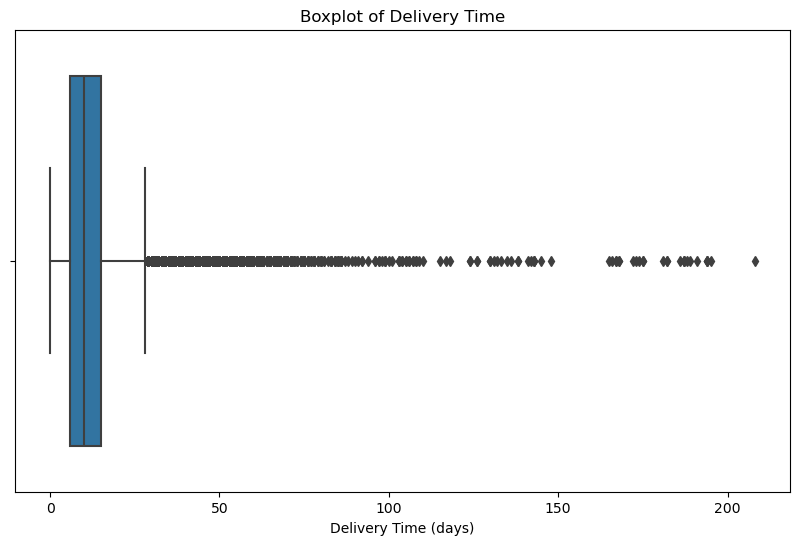

In [32]:
# boxplot do delivery_time
plt.figure(figsize=(10, 6))
sns.boxplot(x=df_model['delivery_time'])
plt.title('Boxplot of Delivery Time')
plt.xlabel('Delivery Time (days)')
plt.show()

In [33]:
Q1 = df_model['delivery_time'].quantile(0.25)
Q3 = df_model['delivery_time'].quantile(0.75)
IQR = Q3 - Q1

# Mantém apenas valores dentro de [Q1 - 1.5*IQR, Q3 + 1.5*IQR]
df_model_filtered = df_model[
    (df_model['delivery_time'] >= Q1 - 1.5 * IQR) & 
    (df_model['delivery_time'] <= Q3 + 1.5 * IQR)
]

In [34]:
# repetir o processo de modelagem com os dados filtrados
X_filtered = df_model_filtered[features]
y_filtered = df_model_filtered['delivery_time']

X_train_filtered, X_test_filtered, y_train_filtered, y_test_filtered = train_test_split(
    X_filtered, y_filtered, test_size=0.2, random_state=42
)

X_train_filtered_scaled = scaler.fit_transform(X_train_filtered)
X_test_filtered_scaled = scaler.transform(X_test_filtered)

model_filtered = RandomForestRegressor(n_estimators=100, random_state=42)
model_filtered.fit(X_train_filtered_scaled, y_train_filtered)


RandomForestRegressor(random_state=42)

In [37]:
# previsões
y_pred_filtered = model_filtered.predict(X_test_filtered_scaled)

mae = mean_absolute_error(y_test_filtered, y_pred_filtered)
rmse = np.sqrt(mean_squared_error(y_test_filtered, y_pred_filtered))
r2 = r2_score(y_test_filtered, y_pred_filtered)

print(f"MAE: {mae:.2f} dias")
print(f"RMSE: {rmse:.2f} dias")
print(f"R²: {r2:.2%}")

MAE: 3.69 dias
RMSE: 4.93 dias
R²: 33.06%
